In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [4]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, make_scorer, f1_score
from imblearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import shap
import json

In [5]:
plt.rc('font', family='NanumBarunGothic')

input & melting & 전처리

In [6]:
recom = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/NH농협캐피탈 데이터 작업_부서이동_1118.csv')
team_code = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/team_code_1111.csv')
personal = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/인적성_1102.xlsx', sheet_name=0, engine='openpyxl')
major = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/전공 대분류_1118.xlsx', engine='openpyxl')

In [7]:
recom =recom.astype({'코드_22년10월' : 'str'})

In [8]:
# 수정 1114
adj = []

for i in range(len(recom)) : 
  if recom['동일부서 근무개월'][i] >= 60 : 
    adj.append('High')
  else : 
    if recom['당사근속기간(개월)'][i] <= 24 : 
      if (recom['역량_22년'][i]=='A' or recom['업적_22년'][i]=='A') : 
        adj.append('Low')
      else : 
        adj.append('Middle')
    else : 
      if (recom['역량_22년'][i]=='A' or recom['업적_22년'][i]=='A') : 
        adj.append('Low')
      elif (recom['역량_22년'][i]=='C' and recom['업적_22년'][i]=='C') : 
        adj.append('High')
      else : 
        adj.append('Middle')

recom['부서이동 필요'] = adj

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [9]:
recom['전공'] = major['대분류']
raw_data = recom

In [10]:
recom = recom.dropna(subset=['팀'], axis=0).reset_index(drop=True)

In [11]:
code = []
for i in range(len(recom)) : 
  for j in range(len(team_code)) : 
    if recom['팀'][i] == team_code['팀'][j] :
      code.append(team_code['코드'][j])

recom['code'] = code

In [12]:
recom_raw = recom.copy()

In [13]:
# encoding 작업
def changing(x) : 
  if str(x) == "S" : 
    return 5
  elif str(x) == "A" : 
    return 4
  elif str(x) == "B" :
    return 3
  elif str(x) == "C" : 
    return 2
  elif str(x) == "D" :
    return 1
  else : 
    return "drop"

In [14]:
for i in [15, 16, 17, 18, 19, 20, 21, 22] : 
  # team_name = '팀_%d년' %i
  power_name = '역량_%d년' %i
  achieve_name = '업적_%d년' %i
  # recom[team_name] = recom[team_name].apply(changing)
  recom[power_name] = recom[power_name].apply(changing)
  recom[achieve_name] = recom[achieve_name].apply(changing)

In [15]:
raw_data = pd.DataFrame(recom[['사번', '성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책',
       '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '학력', '전공', '거주지',
       '직무관련자격증', '수상횟수', '동일부서 근무개월', '부서이동 필요', 'code']])

In [16]:
for name in team_code['코드'].tolist() : 
  name = str(name)
  # team_grade = '팀_'+ name
  power_grade = '역량_' + name
  prize_grade = '업적_' + name
  # raw_data[team_grade] = 0
  raw_data[power_grade] = 0
  raw_data[prize_grade] = 0
  raw_data = raw_data.astype({power_grade : 'float', prize_grade : 'float'})

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [17]:
for i in range(len(recom)) : 
  if recom['코드_15년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_15년12월'][i])
    power_name = '역량_' + str(recom['코드_15년12월'][i])
    prize_name = '업적_' + str(recom['코드_15년12월'][i])
    # if (recom['팀_15년'][i] != 'drop') : 
    #  raw_data[team_name][i] = recom['팀_15년'][i]
    if (recom['역량_15년'][i] != 'drop') :
      raw_data[power_name][i] = recom['역량_15년'][i]
    if (recom['업적_15년'][i] != 'drop') :
      raw_data[prize_name][i] = recom['업적_15년'][i]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
for i in range(len(recom)) : 
  if recom['코드_16년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_16년12월'][i])
    power_name = '역량_' + str(recom['코드_16년12월'][i])
    prize_name = '업적_' + str(recom['코드_16년12월'][i])
    
    # if (recom['팀_16년'][i] != 'drop') : 
    #  if raw_data[team_name][i] == 0 :
    #    raw_data[team_name][i] = recom['팀_16년'][i]
    #  else : 
    #    raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_16년'][i])/2
    if (recom['역량_16년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_16년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_16년'][i])/2
    if (recom['업적_16년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_16년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_16년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
for i in range(len(recom)) : 
  if recom['코드_17년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_17년12월'][i])
    power_name = '역량_' + str(recom['코드_17년12월'][i])
    prize_name = '업적_' + str(recom['코드_17년12월'][i])
    # if (recom['팀_17년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_17년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_17년'][i])/2
    if (recom['역량_17년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_17년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_17년'][i])/2
    if (recom['업적_17년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_17년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_17년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
for i in range(len(recom)) : 
  if recom['코드_18년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_18년12월'][i])
    power_name = '역량_' + str(recom['코드_18년12월'][i])
    prize_name = '업적_' + str(recom['코드_18년12월'][i])
    # if (recom['팀_18년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_18년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_18년'][i])/2
    if (recom['역량_18년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_18년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_18년'][i])/2
    if (recom['업적_18년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_18년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_18년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
for i in range(len(recom)) : 
  if recom['코드_19년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_19년12월'][i])
    power_name = '역량_' + str(recom['코드_19년12월'][i])
    prize_name = '업적_' + str(recom['코드_19년12월'][i])
    # if (recom['팀_19년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_19년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_19년'][i])/2
    if (recom['역량_19년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_19년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_19년'][i])/2
    if (recom['업적_19년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_19년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_19년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
for i in range(len(recom)) : 
  if recom['코드_20년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_20년12월'][i])
    power_name = '역량_' + str(recom['코드_20년12월'][i])
    prize_name = '업적_' + str(recom['코드_20년12월'][i])
    # if (recom['팀_20년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_20년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_20년'][i])/2
    if (recom['역량_20년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_20년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_20년'][i])/2
    if (recom['업적_20년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_20년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_20년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
for i in range(len(recom)) : 
  if recom['코드_21년12월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_21년12월'][i])
    power_name = '역량_' + str(recom['코드_21년12월'][i])
    prize_name = '업적_' + str(recom['코드_21년12월'][i])
    # if (recom['팀_21년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_21년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_21년'][i])/2
    if (recom['역량_21년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_21년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_21년'][i])/2
    if (recom['업적_21년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_21년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_21년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
for i in range(len(recom)) : 
  if recom['코드_22년10월'][i] in list(map(str, team_code['코드'].tolist())) : 
    # team_name = '팀_' + str(recom['코드_22년12월'][i])
    power_name = '역량_' + str(recom['code'][i])
    prize_name = '업적_' + str(recom['code'][i])
    # if (recom['팀_21년'][i] != 'drop') : 
    #   if raw_data[team_name][i] == 0 :
    #     raw_data[team_name][i] = recom['팀_21년'][i]
    #   else : 
    #     raw_data[team_name][i] = (raw_data[team_name][i] + recom['팀_21년'][i])/2
    if (recom['역량_22년'][i] != 'drop') :
      if raw_data[power_name][i] == 0 :
        raw_data[power_name][i] = recom['역량_22년'][i]
      else : 
        raw_data[power_name][i] = (raw_data[power_name][i] + recom['역량_22년'][i])/2
    if (recom['업적_22년'][i] != 'drop') :
      if raw_data[prize_name][i] == 0 :
        raw_data[prize_name][i] = recom['업적_22년'][i]
      else : 
        raw_data[prize_name][i] = (raw_data[prize_name][i] + recom['업적_22년'][i])/2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
raw_data['label'] = 0
raw_data['label_grade'] = 0
raw_data =raw_data.astype({'label_grade' : 'float'})


score = []

for i in range(len(raw_data)) : 
  max = 0
  label_name = 0
  for name in team_code['코드'].tolist() : 
    # avg = (raw_data['팀_' + str(name)][i] + raw_data['역량_' + str(name)][i] + raw_data['업적_' + str(name)][i])/3
    avg = (raw_data['역량_' + str(name)][i] + raw_data['업적_' + str(name)][i])/2
    if avg >= max : 
      max = avg
      label_name = name
  raw_data['label'][i] = label_name
  raw_data['label_grade'][i] = max

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
new_dp = [114000, 423000, 514000, 515000, 644000, 941000]

for i in range(len(raw_data)) : 
  if raw_data['code'][i] in new_dp : 
    raw_data['label'][i] = raw_data['code'][i]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
sec_data = raw_data.copy()

In [28]:
# 인적성 검사 데이터 연결
for name in personal.columns.drop(['성명', '이메일']).tolist() : 
  raw_data = raw_data.join(personal.set_index('이메일')[name], on='이메일')

In [29]:
core_number = raw_data.loc[raw_data['역량 평균'].isna()].index.tolist()

In [30]:
print(len(raw_data))
raw_data.dropna(subset=['역량 평균'], inplace=True) # 인적성검사 미실시자 제거
print(len(raw_data))
raw_data = raw_data.reset_index(drop=True)

277
203


Modeling 전처리 & Modeling

In [31]:
en_data = raw_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직급', '현 직급 근속기간(연)', 'label_grade', 'code'], axis=1).reset_index(drop=True)

In [32]:
en_data['부서이동 필요'].replace({'High' : 3, 'Middle' : 2, 'Low' : 1}, inplace=True)

In [33]:
for name in ['직책', '성별', '학력', '전공', '거주지', '직무'] :
  le = LabelEncoder()
  en_data[name] = le.fit_transform(en_data[name])

In [34]:
X = en_data.drop(['사번', 'label'], axis=1)
y = en_data['label']

In [35]:
random_seed = 4

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=random_seed)

In [37]:

benchmark = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Recall', 'Precision', 'F1 score'])

for algorithm in [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(random_state=random_seed), DecisionTreeClassifier(random_state=random_seed), 
                 AdaBoostClassifier(random_state=random_seed), XGBClassifier(random_state=random_seed), MLPClassifier(random_state=random_seed), ExtraTreesClassifier(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['classifier', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= 'accuracy',
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_train, y_train)
    results_pred = results.predict(X_test)
    acc = accuracy_score(y_test, results_pred)
    recall = recall_score(y_test, results_pred, average='weighted')
    pre = precision_score(y_test, results_pred, average='weighted')
    f1 = f1_score(y_test, results_pred, average='weighted')
    benchmark = benchmark.append({'Algorithm' : algorithm, 'Accuracy' : acc,'Recall' : recall, 'Precision' : pre, 'F1 score' : f1}, ignore_index=True)
  

The least populated class in y has only 1 members, which is less than n_splits=5.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
The least populated class in y has only 1 members, which is less than n_splits=5.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with

In [38]:
benchmark

,Algorithm,Accuracy,Recall,Precision,F1 score
0,LogisticRegression(),0.049180,0.049180,0.076503,0.056831
1,KNeighborsClassifier(),0.081967,0.081967,0.030055,0.043716
2,SVC(),0.098361,0.098361,0.009675,0.017617
3,RandomForestClassifier(random_state=4),0.590164,0.590164,0.502615,0.524128
4,DecisionTreeClassifier(random_state=4),0.360656,0.360656,0.331967,0.332475
5,AdaBoostClassifier(random_state=4),0.213115,0.213115,0.186537,0.182402
6,XGBClassifier(random_state=4),0.524590,0.524590,0.454372,0.469594
7,MLPClassifier(random_state=4),0.262295,0.262295,0.273770,0.239891
8,ExtraTreesClassifier(random_state=4),0.606557,0.606557,0.557650,0.566667


In [39]:
'''
opt_dict = {}
idx = benchmark['Accuracy'].idxmax()
column_list = ['Accuracy', 'Recall', 'Precision', 'F1 score']
benchmark = benchmark.drop([idx], axis=0).reset_index(drop=True) 

for columns in list(column_list) : 
  opt_dict['Average '+columns] = benchmark[columns].mean()

opt_dict  
'''

"\nopt_dict = {}\nidx = benchmark['Accuracy'].idxmax()\ncolumn_list = ['Accuracy', 'Recall', 'Precision', 'F1 score']\nbenchmark = benchmark.drop([idx], axis=0).reset_index(drop=True) \n\nfor columns in list(column_list) : \n  opt_dict['Average '+columns] = benchmark[columns].mean()\n\nopt_dict  \n"

In [40]:
one_label_list = en_data['label'].value_counts().loc[en_data['label'].value_counts()==1].index.tolist()
drop_list = []
for i in range(len(en_data)) : 
  if en_data['label'][i] in one_label_list : 
    drop_list.append(i)

In [41]:
temp_label_data = en_data.copy()
temp_label_data = temp_label_data.drop(drop_list, axis=0)
X = temp_label_data.drop(['사번', 'label'], axis=1)
y = temp_label_data['label']

temp_label = en_data.iloc[drop_list]
temp_x = temp_label.drop(['사번', 'label'], axis=1)
temp_y = temp_label['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)
X_train = X_train.append(temp_x)
y_train = y_train.append(temp_y)

In [42]:
'''
# 최적 seed값 탐색

max = 0
seed_number_rf = 0
rf_number = 0

for seed in range(0, 50) : 
  temp_label_data = en_data.copy()
  temp_label_data = temp_label_data.drop(drop_list, axis=0)
  X = temp_label_data.drop(['사번', 'label'], axis=1)
  y = temp_label_data['label']

  temp_label = en_data.iloc[drop_list]
  temp_x = temp_label.drop(['사번', 'label'], axis=1)
  temp_y = temp_label['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)
  X_train = X_train.append(temp_x)
  y_train = y_train.append(temp_y)
  for num in range(0, 50) : 
    model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=num)
    # model_rf = XGBClassifier(n_estimators=100, max_depth=10, random_state=num)
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_test)
    r2 = accuracy_score(y_test, pred_rf)
    if r2 > max :
      max = r2
      seed_number_rf = seed
      rf_number = num

print(max)
print(seed_number_rf)
print(rf_number)
'''

"\n# 최적 seed값 탐색\n\nmax = 0\nseed_number_rf = 0\nrf_number = 0\n\nfor seed in range(0, 50) : \n  temp_label_data = en_data.copy()\n  temp_label_data = temp_label_data.drop(drop_list, axis=0)\n  X = temp_label_data.drop(['사번', 'label'], axis=1)\n  y = temp_label_data['label']\n\n  temp_label = en_data.iloc[drop_list]\n  temp_x = temp_label.drop(['사번', 'label'], axis=1)\n  temp_y = temp_label['label']\n\n  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)\n  X_train = X_train.append(temp_x)\n  y_train = y_train.append(temp_y)\n  for num in range(0, 50) : \n    model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=num)\n    # model_rf = XGBClassifier(n_estimators=100, max_depth=10, random_state=num)\n    model_rf.fit(X_train, y_train)\n    pred_rf = model_rf.predict(X_test)\n    r2 = accuracy_score(y_test, pred_rf)\n    if r2 > max :\n      max = r2\n      seed_number_rf = seed\n      rf_n

In [43]:
pipeline_xgb = Pipeline(steps=[('classifier', ExtraTreesClassifier(random_state=24))]) # Extra 5 24 0.779 rf

params_xgb={
            'classifier__n_estimators' : [100, 200, 300],
            'classifier__max_depth' : [2, 5, 10], 
            'classifier__min_samples_split' : [2, 5]}


grid_search_xgb = GridSearchCV(estimator=pipeline_xgb,
                               param_grid=params_xgb,
                               scoring = 'accuracy',
                               n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)
pred_xgb = grid_search_xgb.predict(X_test)
pred_proba = grid_search_xgb.predict_proba(X_test)[:,1]
print(grid_search_xgb.best_params_)
now = datetime.now()

acc = accuracy_score(y_test, pred_xgb)
re = recall_score(y_test, pred_xgb, average='weighted')
pre = precision_score(y_test, pred_xgb, average='weighted')
f1 = f1_score(y_test, pred_xgb, average='weighted')

metrics_dict = {}
metrics_dict['accuracy_score'] = acc
metrics_dict['recall_score'] = re
metrics_dict['precision_score'] = pre
metrics_dict['f1_score'] = f1

metrics_dict

The least populated class in y has only 1 members, which is less than n_splits=5.


{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


{'accuracy_score': 0.7755102040816326,
 'recall_score': 0.7755102040816326,
 'precision_score': 0.6571914480077745,
 'f1_score': 0.6989221662691051}

In [44]:
end_model = grid_search_xgb.best_estimator_['classifier']

In [45]:
# Tree 계열 shap으로 변경
explainer = shap.explainers.Tree(end_model, X_train) # 수정
shap_values = explainer.shap_values(X_test, check_additivity=False) 
shap_obj = explainer(X_test, check_additivity=False)

In [46]:
temp = X_train.copy()
code_feature = temp.columns[14:112].tolist()
for name in code_feature : 
  text = name.split('_', 1)
  temp.rename(columns={name : text[0]+"_"+team_code['팀'].loc[team_code['코드']==int(text[1])].reset_index(drop=True)[0]}, inplace=True)

In [47]:
importances = np.absolute(shap_values).sum(axis=0) / len(np.absolute(shap_values).sum(axis=0)[0])

imp = []
for j in range(len(np.absolute(shap_values).sum(axis=0)[0])) : 
  cnt = 0
  for i in range(len(importances)) : 
    cnt += importances[i][j]
  imp.append(cnt)

feature_importance = pd.Series(imp / sum(imp))
feature_importance.index = temp.columns

In [48]:
# 수정 10-26
# team_cnt = 0
power_cnt = 0
prize_cnt = 0

# for i in range(len(feature_importance)) : 
  # if 11+3*i >= 155 :
  #   break
  # else : 
  #   team_cnt += feature_importance[11+3*i]

for i in range(len(feature_importance)) : 
  if 13+2*i >= 112 : # 112
    break
  else : 
    power_cnt += feature_importance[14+2*i]

for i in range(len(feature_importance)) : 
  if 14+2*i >= 112 : # 112 
    break
  else : 
    prize_cnt += feature_importance[15+2*i]

In [49]:
# 수정 10-26
final_feature_imp = feature_importance[0:14]
final_feature_imp = final_feature_imp.append(feature_importance[112:132]) # 112
# final_feature_imp['팀평가등급'] = team_cnt
final_feature_imp['역량평가등급'] = power_cnt
final_feature_imp['업적평가등급'] = prize_cnt
# final_feature_imp['팀별 근속년수'] = feature_importance[155:203].sum()
# final_feature_imp = final_feature_imp.append(feature_importance[203:225])

In [50]:
for name in final_feature_imp.index.drop(['업적평가등급', '역량평가등급']).tolist() : 
  final_feature_imp[name] += final_feature_imp['업적평가등급']*0.5/34 

for name in final_feature_imp.index.drop(['업적평가등급', '역량평가등급']).tolist() : 
  final_feature_imp[name] += final_feature_imp['역량평가등급']*0.5/34 

final_feature_imp['업적평가등급'] = final_feature_imp['업적평가등급']*0.5
final_feature_imp['역량평가등급'] = final_feature_imp['역량평가등급']*0.5

final_feature_imp['성실성'] += final_feature_imp['수상횟수']*0.5
final_feature_imp['수상횟수'] = final_feature_imp['수상횟수']*0.5

final_feature_imp['직무관련자격증'] += final_feature_imp['당사근속기간(개월)']*0.5
final_feature_imp['당사근속기간(개월)'] = final_feature_imp['당사근속기간(개월)']*0.5

final_feature_imp['역량 평균'] += final_feature_imp['연령']*0.5
final_feature_imp['연령'] = final_feature_imp['연령']*0.5

final_feature_imp['사회성'] += final_feature_imp['성별']*0.5
final_feature_imp['성별'] = final_feature_imp['성별']*0.5

In [51]:
fe_dict = final_feature_imp.to_dict()

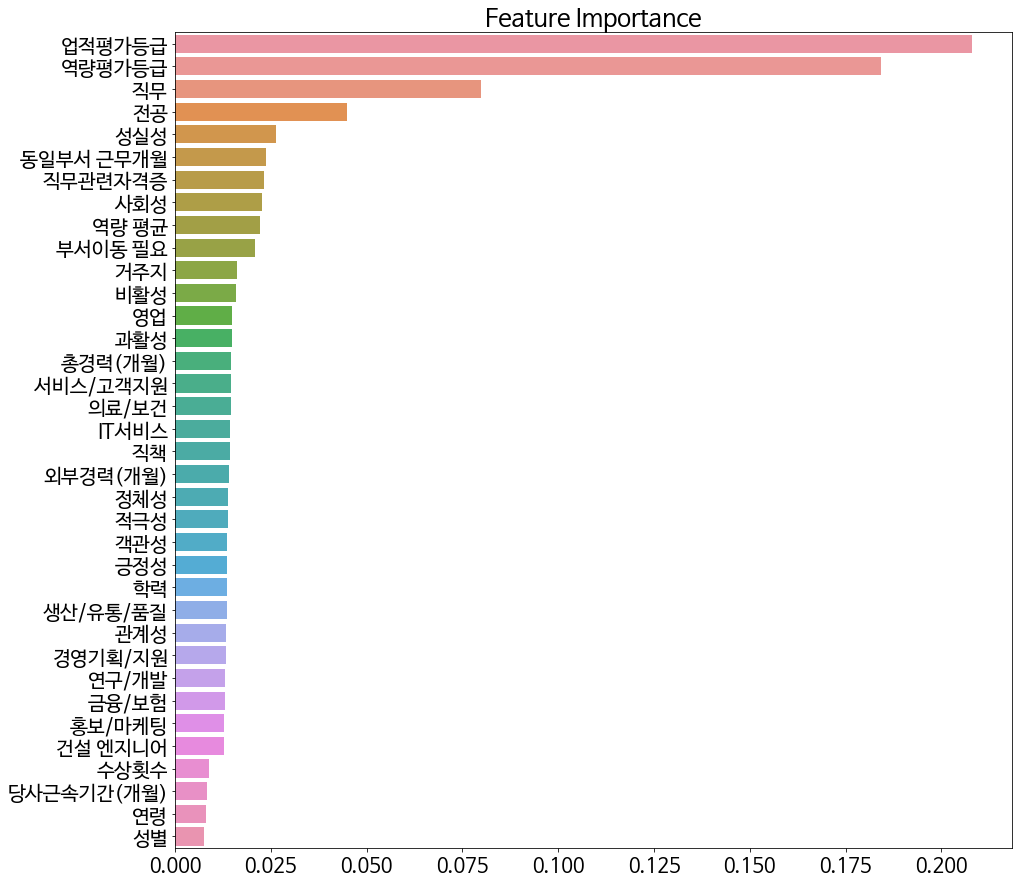

In [52]:
import seaborn as sns

ft_importance = final_feature_imp.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=20)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

In [53]:
# 수정 10-26
missing_rate = {}
feature_data = raw_data[['직책', '직무',
 '성별',
 '연령',
 '당사근속기간(개월)',
 '외부경력(개월)',
 '총경력(개월)',
 '학력',
 '전공',
 '거주지',
 '직무관련자격증',
 '수상횟수', '동일부서 근무개월', '부서이동 필요', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '역량 평균',
       '영업', '연구/개발', 'IT서비스', '경영기획/지원', '생산/유통/품질', '홍보/마케팅', '서비스/고객지원',
       '의료/보건', '건설 엔지니어', '금융/보험', '디자인', '공통']]

for name in feature_data.columns.tolist() : 
  cnt = 0
  for i in range(len(feature_data)) : 
    if feature_data[name].isnull()[i] == True : 
      cnt+=1
  missing_rate[name] = cnt/len(feature_data)

missing_rate['월별 소속팀'] = 0
missing_rate['월별 소속팀 코드'] = 0
missing_rate['팀평가등급'] = 0
missing_rate['업적평가등급'] = 0
missing_rate['역량평가등급'] = 0

inference

In [54]:
inf_x = en_data.drop(['사번', 'label'], axis=1)

In [55]:
predictions = end_model.predict(inf_x)
inf_proba = end_model.predict_proba(inf_x)

In [56]:
output = pd.DataFrame(en_data['사번'], columns=['사번'])
output['predict'] = predictions

for i in range(len(output)) : 
  for j in range(len(team_code)) : 
    if output['predict'][i] == team_code['코드'][j] : 
      output['predict'][i] = team_code['팀'][j]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
i = 0
for name in end_model.classes_ : 
  output[name] = inf_proba[:,i]
  i+=1

In [58]:
feature_name = recom.columns.tolist()
feature_name.remove('사번')

In [59]:
for name in feature_name : 
  output = output.join(recom_raw.set_index('사번')[name], on='사번')

In [60]:
for name in personal.columns.drop(['성명', '이메일']).tolist() : 
  output = output.join(personal.set_index('이메일')[name], on='이메일')

In [61]:
output.drop(['code'], axis=1, inplace=True)

In [62]:
for name in output.columns.tolist() : 
  if name in team_code['코드'].tolist() : 
    output.rename(columns={name : team_code['팀'].loc[team_code['코드']==name].reset_index(drop=True)[0]}, inplace=True)

modeling 2

In [63]:
en_data_2 = sec_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직급', '현 직급 근속기간(연)', 'label_grade', 'code'], axis=1).reset_index(drop=True)

In [64]:
en_data_2['부서이동 필요'].replace({'High' : 3, 'Middle' : 2, 'Low' : 1}, inplace=True)

In [65]:
for name in ['직책', '성별', '학력', '전공', '거주지', '직무'] :
  le = LabelEncoder()
  en_data_2[name] = le.fit_transform(en_data_2[name])

In [66]:
X = en_data_2.drop(['사번', 'label'], axis=1)
y = en_data_2['label']

In [67]:
random_seed = 4

In [68]:
one_label_list = en_data_2['label'].value_counts().loc[en_data_2['label'].value_counts()==1].index.tolist()
drop_list = []
for i in range(len(en_data_2)) : 
  if en_data_2['label'][i] in one_label_list : 
    drop_list.append(i)

In [69]:
temp_label_data_2 = en_data_2.copy()
temp_label_data_2 = temp_label_data_2.drop(drop_list, axis=0)
A = temp_label_data_2.drop(['사번', 'label'], axis=1)
b = temp_label_data_2['label']

temp_label_2 = en_data_2.iloc[drop_list]
temp_a = temp_label_2.drop(['사번', 'label'], axis=1)
temp_b = temp_label_2['label']

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.25, random_state=11, stratify=b)
A_train = A_train.append(temp_a)
b_train = b_train.append(temp_b)

In [70]:
pipeline_xgb_2 = Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))]) # Extra 0 2 rf 

params_xgb_2={
            'classifier__n_estimators' : [100],
            'classifier__max_depth' : [10], 
            'classifier__min_samples_split' : [5]}


grid_search_xgb_2 = GridSearchCV(estimator=pipeline_xgb_2,
                               param_grid=params_xgb_2,
                               scoring = 'accuracy',
                               n_jobs=-1)

grid_search_xgb_2.fit(A_train, b_train)
pred_xgb_2 = grid_search_xgb_2.predict(A_test)
pred_proba_2 = grid_search_xgb_2.predict_proba(A_test)[:,1]
print(grid_search_xgb_2.best_params_)

print(accuracy_score(b_test, pred_xgb_2))
print(recall_score(b_test, pred_xgb_2, average='weighted'))
print(precision_score(b_test, pred_xgb_2, average='weighted'))
print(f1_score(b_test, pred_xgb_2, average='weighted'))

The least populated class in y has only 1 members, which is less than n_splits=5.


{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
0.6231884057971014
0.6231884057971014
0.5170289855072463
0.5424869816174164


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [71]:
end_model_2 = grid_search_xgb_2.best_estimator_['classifier']

In [72]:
# Tree 계열 shap으로 변경
explainer_2 = shap.explainers.Tree(end_model_2, A_train) # 수정
shap_values_2 = explainer_2.shap_values(A_test, check_additivity=False) 
shap_obj = explainer_2(A_test, check_additivity=False)

inference_2

In [73]:
core_data = en_data_2.iloc[core_number].reset_index(drop=True)

In [74]:
# 2021년까지 자료만 있고 2022년 자료(22년 성과)를 반영하기 어려워 학습 및 검증에 사용했던 데이터를 그대로 inference에 활용 / 즉 21년까지의 데이터로 23년의 부서 추천을 한다고 생각
inf_x_2 = core_data.drop(['사번', 'label'], axis=1)

In [75]:
predictions_2 = end_model_2.predict(inf_x_2)
inf_proba_2 = end_model_2.predict_proba(inf_x_2)

In [76]:
output_2 = pd.DataFrame(core_data['사번'], columns=['사번'])
output_2['predict'] = predictions_2

for i in range(len(output_2)) : 
  for j in range(len(team_code)) : 
    if output_2['predict'][i] == team_code['코드'][j] : 
      output_2['predict'][i] = team_code['팀'][j]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
i = 0
for name in end_model_2.classes_ : 
  output_2[name] = inf_proba_2[:,i]
  i+=1

In [78]:
for name in feature_name : 
  output_2 = output_2.join(recom_raw.set_index('사번')[name], on='사번')

In [79]:
output_2.drop(['code'], axis=1, inplace=True)

In [80]:
for name in output_2.columns.tolist() : 
  if name in team_code['코드'].tolist() : 
    output_2.rename(columns={name : team_code['팀'].loc[team_code['코드']==name].reset_index(drop=True)[0]}, inplace=True)

In [81]:
final_output = pd.concat([output, output_2], axis=0).reset_index(drop=True)

In [82]:
new_col_name = final_output.columns[:50].tolist() + final_output.columns[-1:].tolist() + final_output.columns[50:-1].tolist()
final_output = final_output[new_col_name]

In [83]:
main_dict = {}
main_dict['feature importance'] = fe_dict
main_dict['trainset_size'] = len(X_train) + len(inf_x_2)
main_dict['testset_size'] = len(X_test)
main_dict['total_size'] = len(X_train)+len(X_test) + len(inf_x_2)
main_dict['last_train_date'] = str(now)
main_dict['prediction'] = dict()
main_dict['metrics'] = metrics_dict
main_dict['coverage value'] = output['predict'].nunique()
main_dict['coverage rate'] = output['predict'].nunique()/len(team_code)
# main_dict['algorithm others'] = opt_dict
main_dict['feature missing rate'] = missing_rate

In [84]:
main_dict

{'feature importance': {'직무': 0.0798469927100523,
  '직책': 0.014274423370044077,
  '성별': 0.007667175646763072,
  '연령': 0.008086300016807236,
  '당사근속기간(개월)': 0.00825131924306824,
  '외부경력(개월)': 0.014122557299733118,
  '총경력(개월)': 0.014691922688145606,
  '학력': 0.01353546777425135,
  '전공': 0.04483117535628782,
  '거주지': 0.01632055160501968,
  '직무관련자격증': 0.023160849249735684,
  '수상횟수': 0.00899620218286559,
  '동일부서 근무개월': 0.023859211655410353,
  '부서이동 필요': 0.02084037130868257,
  '긍정성': 0.013563947906755226,
  '적극성': 0.01377080267393909,
  '성실성': 0.026362228595587157,
  '사회성': 0.02270647846489451,
  '정체성': 0.013876253381958047,
  '관계성': 0.013353383750070707,
  '객관성': 0.013628093790911,
  '비활성': 0.015946630681498243,
  '과활성': 0.014768479962711425,
  '역량 평균': 0.022232235024444144,
  '영업': 0.014785900309551004,
  '연구/개발': 0.013007289093670434,
  'IT서비스': 0.014410025193621792,
  '경영기획/지원': 0.013342837901122066,
  '생산/유통/품질': 0.013527206889007548,
  '홍보/마케팅': 0.012753058077122683,
  '서비스/고객지원': 0.014

In [85]:
json_file = json.dumps(main_dict)

In [86]:
file_path = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/부서이동.json'

In [87]:
with open(file_path, 'w', encoding='utf-8-sig') as file:
    file.write(json.dumps(main_dict, ensure_ascii=False))

filtering (근무부서코드에 따라 로직 변경요소 많음)

In [88]:
# 필터링 조건 부여
# 1. high에 속한 인원인데 본인 부서 추천했을 경우 해당목록 제외하고 4순위 가져오기
# 2. 추천 부서에 지점이 있을 경우 거주지 정보 탐색해서 본인 거주지와 불일치, 가깝지 않을 경우 거주지에 맞추어 추천
# 
predict_rank = []

# High인 인원들은 현직급부서 제외
for i in range(len(final_output)) : 
  rank_list = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[0:3].tolist()
  if final_output['부서이동 필요'][i] == 'High' : 
    if final_output['팀'][i] in rank_list : 
      rank_list.remove(final_output['팀'][i])
      rank_list.append(final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4])
  predict_rank.append(rank_list)

In [89]:
sector_dict = {}

sector_dict['평택지점'] = '경기'
sector_dict['대전지점'] = ['대전', '세종', '충북']
sector_dict['광주지점'] = '광주'

sector_dict['서울1지점'] = ['서울', '경기']
sector_dict['서울2지점'] = ['서울', '경기']
sector_dict['인천지점'] = '인천'

sector_dict['부산지점'] = '부산'
sector_dict['대구지점'] = '대구'
sector_dict['창원출장소'] = '경남'

In [90]:
for i in range(len(predict_rank)) : # 추천 부서 읽기
  for j in range(3) : # 부서 3개
    if predict_rank[i][j] in list(sector_dict.keys()) : # 만약 추천 리스트에 지점이 있을 경우
      if type(sector_dict[predict_rank[i][j]]) == str : # dictionary가 단일 문자일 경우
        if sector_dict[predict_rank[i][j]] != final_output['거주지'][i] : # 지점 value값이 사는 거주지와 다를 경우
          if final_output['거주지'][i] == '서울'  : 
            predict_rank[i][j] = '서울1지점'
          elif final_output['거주지'][i] =='경기' : 
            predict_rank[i][j] == '평택지점'
          elif final_output['거주지'][i] == '대전' or final_output['거주지'][i] == '세종' or final_output['거주지'][i] == '충북' : 
            predict_rank[i][j] = '대전지점' 
          else : 
            nearby = [k for k, v in sector_dict.items() if v == final_output['거주지'][i]] # 거주지 인근 지점 찾기
            predict_rank[i][j] = nearby[0] # 거주지 인근 지점을 추천리스트로 대체
      else : # dict가 list일 경우
        if final_output['거주지'][i] not in sector_dict[predict_rank[i][j]] : 
          if final_output['거주지'][i] == '서울'  : 
            predict_rank[i][j] = '서울1지점'
          elif final_output['거주지'][i] =='경기' : 
            predict_rank[i][j] == '평택지점'
          elif final_output['거주지'][i] == '대전' or final_output['거주지'][i] == '세종' or final_output['거주지'][i] == '충북' : 
            predict_rank[i][j] = '대전지점' 
          else : 
            nearby = [k for k, v in sector_dict.items() if v == final_output['거주지'][i]] # 거주지 인근 지점 찾기
            predict_rank[i][j] = nearby[0] # 거주지 인근 지점을 추천리스트로 대체

In [91]:
for i in range(len(predict_rank)) : # 추천 부서 읽기
  cnt = 0 # 추천된 부서 지점 개수 세기
  for j in range(3) : 
    if predict_rank[i][j] in list(sector_dict.keys()) : 
      cnt+=1
  
  if cnt == 2 : # 추천 부서에 지점 개수가 2개인 경우
    for j in range(2, -1, -1) : # predict_3부터 바꾸기
      if predict_rank[i][j] in list(sector_dict.keys()) : # 지점이 포함되어 있으면 4번째 추천 부서를 가져오는데 기존 추천 리스트에 없고 and 지점이 아닐경우 
        if final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3] not in list(sector_dict.keys()) and final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3] not in predict_rank[i] : 
          predict_rank[i][j] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3]
        else : # 기존 추천 리스트에 있거나 지점일 경우에는 5번째 추천 부서 가져오기 + 한번 더 걸러내서 6번째까지 추천
          if final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4] not in list(sector_dict.keys()) and final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4] not in predict_rank[i] : 
            predict_rank[i][j] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4]
          else : 
            predict_rank[i][j] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[5]
        break # 한번만 바꾸면 되기에 중단
      
  elif cnt == 3 : # 추천 부서에 지점 개수가 3개인 경우
      if final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3] not in list(sector_dict.keys()) and final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3] not in predict_rank[i] : 
        predict_rank[i][2] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[3]
      else : 
        predict_rank[i][2] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4]
      if final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4] not in list(sector_dict.keys()) and final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4] not in predict_rank[i] : 
        predict_rank[i][1] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[4]
      else : 
        if final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[5] not in list(sector_dict.keys()) and final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[5] not in predict_rank[i] : 
          predict_rank[i][1] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[5]
        else:  
          predict_rank[i][1] = final_output[final_output.columns[2:51]].sort_values(by=i, axis=1, ascending=False).columns[6]

In [92]:
final_output[['predict_1', 'predict_2', 'predict_3']] = predict_rank

In [93]:
col_list = final_output.columns.tolist()
new_col_list = col_list[0:1]+col_list[-3:]+col_list[1:-3]

final_output = final_output[new_col_list]

final_output.drop(final_output.columns[4:54].tolist(), axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [94]:
final_output.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
# 수정 1116
attrition = ['정희진', '박영민', '강도이', '박상완', '김봉식']
attrition_idx = []
for i in range(len(final_output)) : 
 if final_output['성명'][i] in attrition : 
   attrition_idx.append(i)

final_output.drop(attrition_idx, inplace=True)

In [96]:
final_output.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/output_부서이동.csv', encoding='utf-8-sig', index=False)

feature_weight_1

In [97]:
shap_values_inf = explainer.shap_values(inf_x, check_additivity=False)

 99%|===================| 9685/9744 [00:37<00:00]       

In [98]:
feature_weight_list = []

for j in range(len(inf_x)) : 
  id = en_data['사번'][j]
  for i in range(len(end_model.classes_)) : 
    classes = end_model.classes_[i]    
    sum = np.absolute(shap_values_inf[i][j]).sum()
    value_list = []
    value_list.append(id)
    value_list.append(classes)
    for k in range(len(inf_x.columns)) :
      if shap_values_inf[i][j][k] > 0 :
        values = shap_values_inf[i][j][k] / sum
        value_list.append(values)
      else : 
        values = np.absolute(shap_values_inf[i][j][k]) / sum
        value_list.append(values)
    feature_weight_list.append(value_list)

In [99]:
feature_weight_columns = ['사번', 'classes']
for name in inf_x.columns.tolist() : 
  feature_weight_columns.append(name)

feature_weight = pd.DataFrame(feature_weight_list, columns = feature_weight_columns)

for i in range(len(feature_weight)) : 
  for j in range(len(team_code)) : 
    if feature_weight['classes'][i] == team_code['코드'][j] : 
      feature_weight['classes'][i] = team_code['팀'][j]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [100]:
code_feature = feature_weight.columns[16:114].tolist()
for name in code_feature : 
  text = name.split('_', 1)
  feature_weight.rename(columns={name : text[0]+"_"+team_code['팀'].loc[team_code['코드']==int(text[1])].reset_index(drop=True)[0]}, inplace=True)

In [101]:
for name in team_code['팀'].tolist() : 
  if '역량_'+name in feature_weight.columns.tolist() : 
    # feature_weight[name] = feature_weight['팀_'+name] + feature_weight['역량_'+name] + feature_weight['업적_'+name] + feature_weight['근속년수_'+name]
    feature_weight[name] = feature_weight['역량_'+name] + feature_weight['업적_'+name]

In [102]:
final_feature_weight = feature_weight.drop(feature_weight.columns[16:114].tolist(), axis=1)

feature_weight_2

In [103]:
shap_values_inf_2 = explainer_2.shap_values(inf_x_2, check_additivity=False)

 93%|=================== | 3358/3626 [00:11<00:00]       

In [104]:
feature_weight_list_2 = []

for j in range(len(inf_x_2)) : 
  id = core_data['사번'][j]
  for i in range(len(end_model_2.classes_)) : 
    classes = end_model_2.classes_[i]    
    sum = np.absolute(shap_values_inf_2[i][j]).sum()
    value_list = []
    value_list.append(id)
    value_list.append(classes)
    for k in range(len(inf_x_2.columns)) :
      if shap_values_inf_2[i][j][k] > 0 :
        values = shap_values_inf_2[i][j][k] / sum
        value_list.append(values)
      else : 
        values = np.absolute(shap_values_inf_2[i][j][k]) / sum
        value_list.append(values)
    feature_weight_list_2.append(value_list)

In [105]:
feature_weight_columns_2 = ['사번', 'classes']
for name in inf_x_2.columns.tolist() : 
  feature_weight_columns_2.append(name)

feature_weight_2 = pd.DataFrame(feature_weight_list_2, columns = feature_weight_columns_2)

for i in range(len(feature_weight_2)) : 
  for j in range(len(team_code)) : 
    if feature_weight_2['classes'][i] == team_code['코드'][j] : 
      feature_weight_2['classes'][i] = team_code['팀'][j]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [106]:
code_feature_2 = feature_weight_2.columns[16:114].tolist()
for name in code_feature_2 : 
  text = name.split('_', 1)
  feature_weight_2.rename(columns={name : text[0]+"_"+team_code['팀'].loc[team_code['코드']==int(text[1])].reset_index(drop=True)[0]}, inplace=True)

In [107]:
for name in team_code['팀'].tolist() : 
  if '역량_'+name in feature_weight_2.columns.tolist() : 
    # feature_weight_2[name] = feature_weight_2['팀_'+name] + feature_weight_2['역량_'+name] + feature_weight_2['업적_'+name] + feature_weight_2['근속년수_'+name]
    feature_weight_2[name] = feature_weight_2['역량_'+name] + feature_weight_2['업적_'+name]

In [108]:
final_feature_weight_2 = feature_weight_2.drop(feature_weight_2.columns[16:114].tolist(), axis=1)

In [109]:
final_feature_weight_f = pd.concat([final_feature_weight, final_feature_weight_2], axis=0)

In [110]:
final_feature_weight_f.fillna(0, inplace=True)

In [111]:
final_feature_weight_f.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/feature_weight_부서이동.csv', encoding='utf-8-sig', index=False)

In [112]:
'''
# 검증코드 / 대표님 보고용으로 제거해도 무방

prove = pd.DataFrame(output['사번'])
prove[output.columns.tolist()[2:42]] = output[output.columns.tolist()[2:42]]
prove.drop(['사번'], axis=1, inplace=True)
temp = pd.DataFrame(output['사번'])

for i in range(len(prove.columns)) : 
  name = '%d순위' % i
  temp[name] = 0

for i in range(len(prove)) : 
  order = prove.iloc[i].sort_values(ascending=False).index.tolist()
  for j in range(len(order)) : 
    name = '%d순위' % j
    temp[name][i] = order[j]

tempp = pd.DataFrame(output['사번'])
for i in range(len(prove.columns)) : 
  name = '%d순위 확률' % i
  tempp[name] = 0

tempp.drop(['사번'], axis=1, inplace=True)

aa = []

for i in range(len(prove)) : 
  order = prove.iloc[i].sort_values(ascending=False).values.tolist()
  aa.append(order)

tt = pd.DataFrame(aa, columns=tempp.columns)

temp[['15년12월', '16년12월', '17년12월', '18년12월', '19년12월', '20년12월', '21년12월', '팀']] = output[['15년12월', '16년12월', '17년12월', '18년12월', '19년12월', '20년12월', '21년12월', '팀']]

ppp = pd.concat([temp, tt], axis=1)
ppp.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/부서이동/부서이동 검증.csv', encoding='utf-8-sig', index=False)
'''

"\n# 검증코드 / 대표님 보고용으로 제거해도 무방\n\nprove = pd.DataFrame(output['사번'])\nprove[output.columns.tolist()[2:42]] = output[output.columns.tolist()[2:42]]\nprove.drop(['사번'], axis=1, inplace=True)\ntemp = pd.DataFrame(output['사번'])\n\nfor i in range(len(prove.columns)) : \n  name = '%d순위' % i\n  temp[name] = 0\n\nfor i in range(len(prove)) : \n  order = prove.iloc[i].sort_values(ascending=False).index.tolist()\n  for j in range(len(order)) : \n    name = '%d순위' % j\n    temp[name][i] = order[j]\n\ntempp = pd.DataFrame(output['사번'])\nfor i in range(len(prove.columns)) : \n  name = '%d순위 확률' % i\n  tempp[name] = 0\n\ntempp.drop(['사번'], axis=1, inplace=True)\n\naa = []\n\nfor i in range(len(prove)) : \n  order = prove.iloc[i].sort_values(ascending=False).values.tolist()\n  aa.append(order)\n\ntt = pd.DataFrame(aa, columns=tempp.columns)\n\ntemp[['15년12월', '16년12월', '17년12월', '18년12월', '19년12월', '20년12월', '21년12월', '팀']] = output[['15년12월', '16년12월', '17년12월', '18년12월', '19년12월', '20년12월', '21년12월'

In [113]:
final_output

,사번,predict_1,predict_2,predict_3,성명,연락처,이메일,생년월일,본부,실,...,IT서비스,경영기획/지원,생산/유통/품질,홍보/마케팅,서비스/고객지원,의료/보건,건설 엔지니어,금융/보험,디자인,공통
0,B0810003,리스크검증팀,서울1지점,IT운영팀,변홍구,010-9570-2340,byunhg@nhcapital.co.kr,1964-05-12,리스크관리본부,리스크관리실,...,71.54,74.04,75.55,70.67,67.48,70.82,75.46,69.06,69.57,69.02
1,B0810007,IT개선팀,디지털전략팀,서울1지점,이창준,010-6532-3351,cjlee@nhcapital.co.kr,1972-02-20,디지털금융본부,DT추진센터,...,66.52,59.19,60.52,63.60,55.97,55.70,64.23,57.30,60.94,63.32
2,B0810024,기업심사팀,기업금융1팀,ESG추진팀,김진영,010-9174-9850,jykim@nhcapital.co.kr,1980-11-23,기업금융본부,기업금융실,...,55.21,60.02,52.56,55.87,63.46,54.11,51.20,66.58,56.69,61.97
3,B0910010,디지털영업기획팀,경영전략팀,오토기획팀,이상명,010-2500-1121,smlee@nhcapital.co.kr,1981-12-19,디지털금융본부,디지털영업실,...,75.32,72.77,72.47,72.95,73.88,66.05,60.82,78.57,74.36,72.03
4,B1010001,서울2지점,오토다이렉트지점,리테일심사팀,서용원,010-8761-9675,seoyw@nhcapital.co.kr,1966-05-01,리스크관리본부,리스크관리실,...,49.43,51.12,53.24,50.89,56.70,55.22,48.74,52.79,55.15,50.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,B2210052,리테일기획팀,부산지점,FLEET금융팀,이민설,010-4464-4442,seol@nhcapital.co.kr,1989-04-24,리테일금융본부,리테일영업3센터,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,B2210074,전략영업2팀,전략영업1팀,디지털전략팀,송자훈,010-4723-6700,jhsong@nhcapital.co.kr,1987-01-29,전략금융본부,전략영업실,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,B2210116,신용분석팀,서울1지점,리테일다이렉트지점,전재홍,010-3304-9084,jjh@nhcapital.co.kr,1989-04-11,리스크관리본부,리스크관리실,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,B2210117,경영지원팀,서울2지점,기업심사팀,박대용,010-4162-1055,pdy1055@nhcapital.co.kr,1989-11-29,경영지원본부,경영기획실,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
qqqq = output[[
 '연령',
 '당사근속기간(개월)',
 '외부경력(개월)',
 '총경력(개월)',
 '직무관련자격증',
 '수상횟수', '동일부서 근무개월', '부서이동 필요', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '역량 평균',
       '영업', '연구/개발', 'IT서비스', '경영기획/지원', '생산/유통/품질', '홍보/마케팅', '서비스/고객지원',
       '의료/보건', '건설 엔지니어', '금융/보험', '디자인', '공통', '역량_15년',
       '역량_16년', '역량_17년', '역량_18년', '역량_19년', '역량_20년', '역량_21년', '역량_22년',
       '업적_15년', '업적_16년', '업적_17년', '업적_18년', '업적_19년', '업적_20년', '업적_21년', '업적_22년']]

team_name = ['경영전략팀', '경영지원팀', '재무팀', '업무혁신팀', 'IT통합지원실(정보보호반)',
       'IT운영팀', 'IT개선팀', '리스크관리팀', '신용분석팀', '리스크검증팀', '리테일심사팀', '기업심사팀',
       '여신관리기획팀', '여신관리팀', '여신관리지원팀', '기업금융1팀', '기업금융2팀', '기업금융3팀', '투자금융1팀',
       '투자금융2팀', '기업금융기획팀', 'ESG추진팀', '글로벌사업팀', 'FLEET금융팀', '전략영업1팀', '전략영업2팀',
       '리테일영업지원팀', '리테일기획팀', '오토기획팀', '오토자산운영팀', '서울1지점', '인천지점', '서울2지점',
       '광주지점', '대전지점', '평택지점', '부산지점', '대구지점', '창원출장소', '디지털영업지원팀', '디지털영업기획팀',
       '리테일다이렉트지점', '오토다이렉트지점', '디지털전략팀', '고객지원팀', '감사팀', '준법지원팀', '소비자보호팀']
qqqq[team_name] = output[team_name]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [115]:
grade_list = ['역량_15년',
       '역량_16년', '역량_17년', '역량_18년', '역량_19년', '역량_20년', '역량_21년', '역량_22년',
       '업적_15년', '업적_16년', '업적_17년', '업적_18년', '업적_19년', '업적_20년', '업적_21년',
       '업적_22년']

for column in grade_list : 
  for i in range(len(qqqq)) : 
    if qqqq[column][i] == 'S' :
      qqqq[column][i] = 5
    elif qqqq[column][i] == 'A' :
      qqqq[column][i] = 4
    elif qqqq[column][i] == 'B' :
      qqqq[column][i] = 3
    elif qqqq[column][i] == 'C' :
      qqqq[column][i] = 2
    elif qqqq[column][i] == 'D' :
      qqqq[column][i] = 1
    else : 
      qqqq[column][i] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [116]:
qqqq.replace('Low', 3, inplace=True)
qqqq.replace('Middle', 2, inplace=True)
qqqq.replace('High', 1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [117]:
ffff= qqqq.corr(method='pearson')

In [118]:
pppp = ffff[team_name]

In [119]:
pppp.drop(team_name, axis=0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [134]:
pppp.max().max()

0.36551019198808127

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


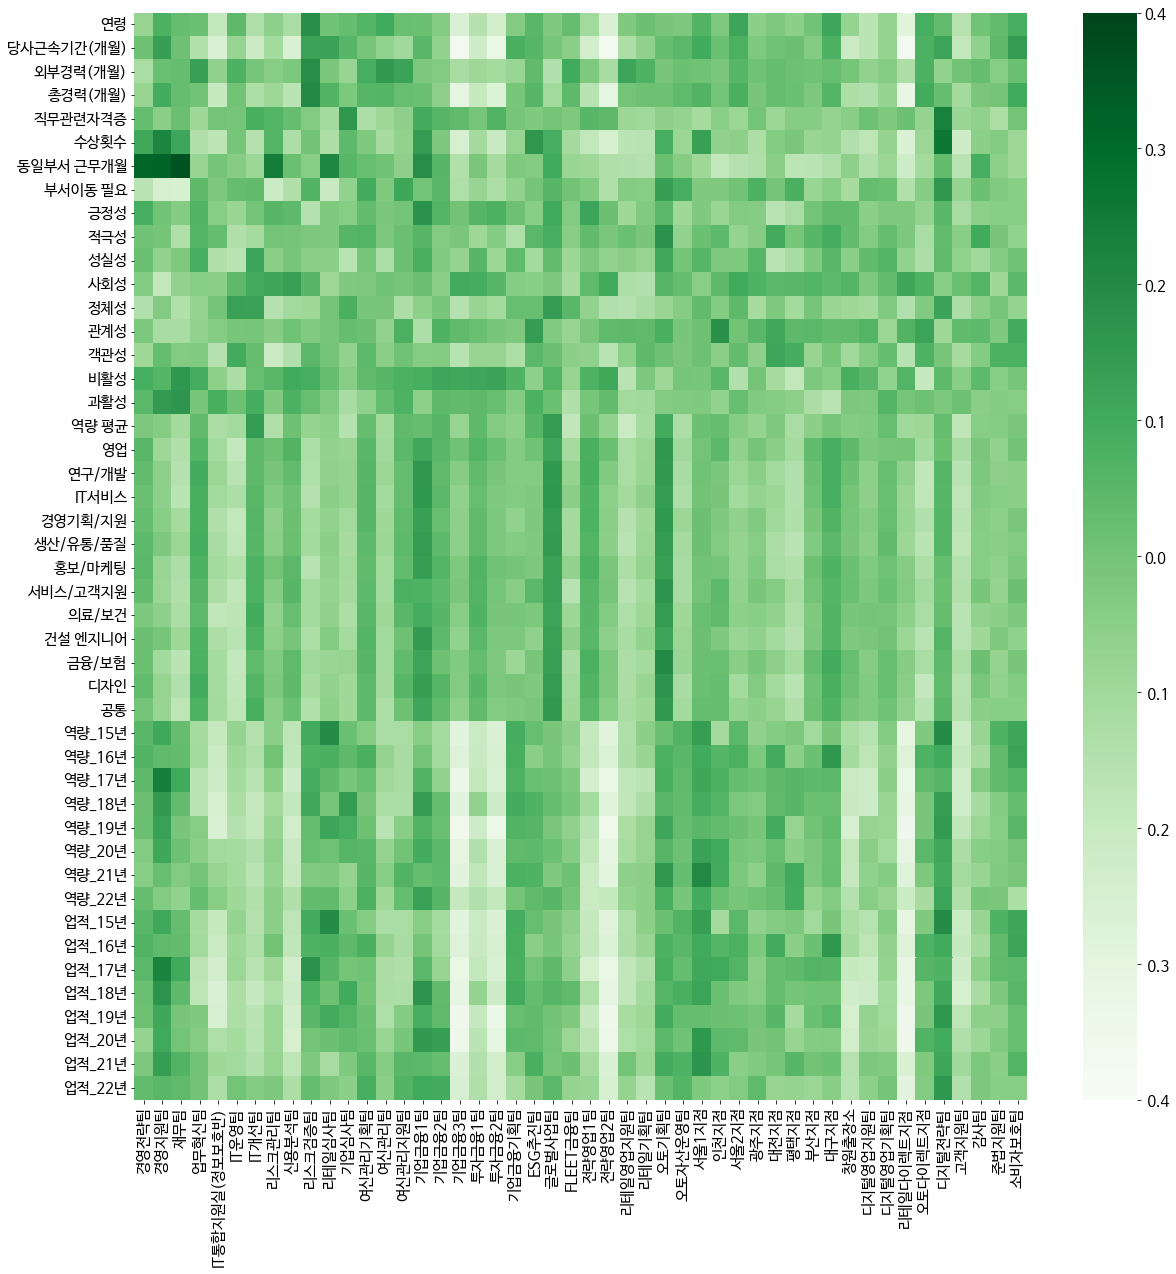

In [139]:
# heatmap
plt.rcParams["figure.figsize"] = (20, 20)
plt.rc('font', size=15)
sns.heatmap(pppp,
           annot = False, #실제 값 화면에 나타내기
            fmt=".2f",
           cmap = 'Greens', #색상
           vmin = -0.4, vmax=0.4 , #컬러차트 영역 -1 ~ +1
          )

In [142]:
raw_data.loc[raw_data['팀']=='IT개선팀']

,사번,성명,연락처,이메일,생년월일,본부,실,팀,직무,직급,...,IT서비스,경영기획/지원,생산/유통/품질,홍보/마케팅,서비스/고객지원,의료/보건,건설 엔지니어,금융/보험,디자인,공통
17,B1110066,유연선,010-8898-9422,yeonsun@nhcapital.co.kr,1981-08-31,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),차장,...,82.72,84.02,85.42,81.62,77.54,76.20,79.55,79.60,79.90,76.00
56,B1410038,육남현,010-6742-2916,tintin94@nhcapital.co.kr,1976-02-14,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),차장,...,69.72,72.13,72.22,71.53,69.31,72.20,77.82,66.78,72.12,70.63
76,B1610032,노주원,010-6358-5115,juwonroh@nhcapital.co.kr,1982-01-30,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),과장,...,87.40,88.46,90.32,84.78,76.53,89.26,98.64,78.67,83.00,82.48
126,B1910043,박승종,010-9351-7451,seungjong25@nhcapital.co.kr,1986-07-08,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),과장,...,70.77,72.05,73.31,66.81,67.19,61.14,72.77,69.32,66.49,72.66
132,B1910069,김현수,010-2679-2171,hskim92@nhcapital.co.kr,1992-11-10,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),계장,...,87.95,84.22,85.80,84.37,81.29,83.50,89.63,83.83,84.64,85.12
139,B2010048,강동완,010-4016-7057,kdw2134@nhcapital.co.kr,1988-05-29,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),대리,...,89.63,85.86,85.79,85.19,79.02,82.46,88.34,84.06,84.46,85.30
144,B2010100,김유정,010-7600-3562,no1feel@nhcapital.co.kr,1989-01-11,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),대리,...,77.70,80.48,80.39,83.62,83.85,82.74,81.60,81.08,82.70,82.36
152,B2110061,노지원,010-7746-9505,qkqhdi3210@nhcapital.co.kr,1995-03-11,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),계장,...,61.11,63.79,62.35,60.56,65.61,63.00,62.48,61.08,58.79,64.30
161,B2110108,고기광,010-6367-9239,kkko@nhcapital.co.kr,1990-09-12,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),계장,...,69.81,75.63,73.55,71.41,69.44,73.08,73.12,72.04,70.35,72.59
163,B2110114,임재일,010-5219-2330,imjaeil@nhcapital.co.kr,1984-11-27,경영지원본부,IT통합지원실,IT개선팀,IT지원(개발),과장,...,42.00,52.15,49.91,42.00,49.20,44.45,49.31,44.08,42.00,43.40
